# 3-Node Congestion Identification and Redispatch Market: Germany

## Single bidding zone with fixed load, one period: Germany

### 1)Import Packages

In [2]:
import pypsa
#import pandapower as pp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging
from collections import Counter

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.getcwd()

'/nimble/home/par19744/ASSUME_network'

In [4]:
os.chdir("/nimble/home/par19744/ASSUME_network")

if not os.path.exists("/nimble/home/par19744/ASSUME_network/outputs"):
    os.makedirs("/nimble/home/par19744/ASSUME_network/outputs")
else:
    print(f"The directory already exists.")

The directory already exists.


### 2)Create a network and set Snapshots

In [5]:
# Create a new PyPSA network
network = pypsa.Network()
solver='glpk'

In [6]:
network.set_snapshots(pd.date_range("2024-01-01", periods=24, freq="H"))

In [7]:
network.snapshots

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               '2024-01-01 10:00:00', '2024-01-01 11:00:00',
               '2024-01-01 12:00:00', '2024-01-01 13:00:00',
               '2024-01-01 14:00:00', '2024-01-01 15:00:00',
               '2024-01-01 16:00:00', '2024-01-01 17:00:00',
               '2024-01-01 18:00:00', '2024-01-01 19:00:00',
               '2024-01-01 20:00:00', '2024-01-01 21:00:00',
               '2024-01-01 22:00:00', '2024-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')

### 3)Add Buses

In [7]:
# Read excel file which contains Non renewable generators data
def add_buses(filename,header):
    try:
        bus_data = pd.read_csv(filename,header=header)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return
        
    for index,row in bus_data.iterrows():
        network.add(
            "Bus",
            name=row['bus'],
            v_nom=row['v_nom'],
            carrier=row['carrier'],
            x=row['x'],
            y=row['y']
            )
    return network.buses

In [8]:
add_buses('buses.csv',0)

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
no_de,380.0,,9.598,53.5585,AC,,1.0,0.0,inf,PQ,,
ost_de,380.0,,13.607,51.0769,AC,,1.0,0.0,inf,PQ,,
west_de,380.0,,6.802,50.9578,AC,,1.0,0.0,inf,PQ,,


### 4)Add generators

In [9]:
def add_generators(filename, index_col):
    try:
        generator_data = pd.read_csv(filename,index_col=index_col)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return
    
    generators_da = generator_data.copy()
    generators_da['p_max_pu'] = generators_da['p_da'] / generators_da['p_nom']
    generators_da['p_min_pu']= generators_da['p_da'] / generators_da['p_nom']
    grouped_data_da = generators_da.groupby('name').agg(lambda x: x.tolist()).reset_index()
    
    # Iterate through time steps and add generators
    for index,row in grouped_data_da.iterrows():   
        network.add("Generator",
                    name=row['name'],
                    bus=' '.join(set(row['bus'])),
                    p_set=row['p_da'],
                    p_nom=' '.join(map(str, set(row['p_nom']))),
                    marginal_cost=row['marginal_cost'],
                    p_nom_extendable=False,
                    p_max_pu=row['p_max_pu'],
                    p_min_pu=row['p_min_pu'],
                    carrier=' '.join(set(row['carrier']))
                )

    return network.generators_t.p_set.head(5)

In [10]:
add_generators('generators_t.csv',0)

Generator,gen_no1,gen_ost1,gen_west1
snapshot,,,
2024-01-01 00:00:00,31.0,4.0,0.0
2024-01-01 01:00:00,31.0,3.0,0.0
2024-01-01 02:00:00,31.0,3.0,0.0
2024-01-01 03:00:00,31.0,2.0,0.0
2024-01-01 04:00:00,31.0,6.0,0.0


### 5)Add load

In [11]:
# Read excel file which contains Non renewable generators data
def add_consumers(filename, index_col):
    try:
        load = pd.read_csv(filename,index_col=index_col)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return

    for load_name in list(load.columns.unique()):
        network.add("Load",
        f"{load_name}",
        bus=load_name,
        p_set=load[load_name].tolist()
        )

    return network.loads_t.p_set.head(5), network.loads_t.p_set.plot(figsize=(6,3), ylabel="MW")

(Load                 no_de  ost_de  west_de
 snapshot                                   
 2024-01-01 00:00:00    4.0    11.0     20.0
 2024-01-01 01:00:00    3.0    10.0     21.0
 2024-01-01 02:00:00    3.0    12.0     19.0
 2024-01-01 03:00:00    2.0    11.0     20.0
 2024-01-01 04:00:00    3.0    12.0     22.0,
 <AxesSubplot:xlabel='snapshot', ylabel='MW'>)

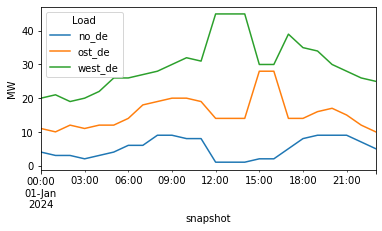

In [12]:
add_consumers('consumers_t.csv',0)

### 6)Add Transmission lines

In [13]:
def add_lines(filename, header):
    try:
        lines = pd.read_csv(filename, header=header)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return
        
    for index, row in lines.iterrows():
        network.add(
            "Line",
            "{}".format(index),
            bus0=row['bus0'],
            bus1=row['bus1'],
            s_nom=row['s_nom'],
            x=1,
            s_nom_extendable=row['s_nom_extendable']
        )
    return network.lines.head()

In [14]:
add_lines('lines.csv',0)

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
0,no_de,ost_de,,1.0,0.0,0.0,0.0,12.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ost_de,west_de,,1.0,0.0,0.0,0.0,12.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,west_de,no_de,,1.0,0.0,0.0,0.0,12.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 8)Congestion identification

In [15]:
def congestion_identification():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=DeprecationWarning)
    
    zero_r_lines = network.lines.index[network.lines.r == 0]      # A small non-zero value for resistance in lines with zero resistance
    network.lines.loc[zero_r_lines, 'r'] = 1e-9  
    congestion_info = []
    network.pf()

    line_index_counter = Counter()

    for timestep in network.snapshots:
        for index, (loading, s_nom_value) in enumerate(zip(np.round(np.abs(network.lines_t.p0.values.flatten())), network.lines.s_nom)):
            net_loading = loading - s_nom_value
            congestion_status = net_loading > 0
            congestion_info.append({
                "timestamp":timestep,
                "line_index": network.lines.index[index],
                "nominal_grid_cap": s_nom_value,
                "line_loading": loading,
                "net_loading": net_loading, 
                "congestion_status": congestion_status
            })

            if congestion_status:
                line_index_counter[network.lines.index[index]] += 1

    congestion_df = pd.DataFrame(congestion_info)
    congestion = (lambda x: "Network is congested" if x.any() else "There is no congestion")(congestion_df['congestion_status'])
    
    counter_df = pd.DataFrame(list(line_index_counter.items()), columns=['line_index', 'congestion_count'])
    counter_df.to_csv("outputs/congestion_count.csv", index=False)
    
    print(f"Congestion count for each line_index:\n {counter_df}")
    
    return congestion_df

In [16]:
congestion_info=congestion_identification()
congestion_info.head()

Congestion count for each line_index:
   line_index  congestion_count
0          2                24


,timestamp,line_index,nominal_grid_cap,line_loading,net_loading,congestion_status
0,2024-01-01 00:00:00,0,12.0,11.0,-1.0,False
1,2024-01-01 00:00:00,1,12.0,4.0,-8.0,False
2,2024-01-01 00:00:00,2,12.0,16.0,4.0,True
3,2024-01-01 01:00:00,0,12.0,11.0,-1.0,False
4,2024-01-01 01:00:00,1,12.0,4.0,-8.0,False


### 9)Redispatch

In [17]:
def redispatch():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=DeprecationWarning)
    congestion_info=congestion_identification()
    redispatch_info = []

    if congestion_info['congestion_status'].any():
        redisp_network=network.copy()
        redisp_network.lines['s_nom_extendable'] = False
        redisp_network.generators['control'] = 'PQ'
        line_index_counter = Counter()
        
        # 1. Adding Positive redispatch generator capacity
        try:
            generator_data = pd.read_csv('generators_t.csv',index_col=0)
        except pd.errors.EmptyDataError:
            print("The CSV file is empty.")

        generator_data_pos = generator_data.copy()   
        generator_data_pos['p_max_pu'] = (generator_data_pos['p_nom']-generator_data_pos['p_da'])/ (generator_data_pos['p_nom'])
        generator_data_pos['p_min_pu']= 0
        grouped_data_pos = generator_data_pos.groupby('name').agg(lambda x: x.tolist()).reset_index()
        grouped_data_pos['p_nom'] = grouped_data_pos['p_nom'].apply(lambda x: x[0] if len(set(x)) == 1 else x)

        for index,row in grouped_data_pos.iterrows():   
            redisp_network.add("Generator",
                        name=f"posredisp_{row['name']}",
                        bus=' '.join(set(row['bus'])),
                        marginal_cost=row['marginal_cost'],
                        p_nom_extendable=False,
                        p_nom=row['p_nom'],
                        p_max_pu=row['p_max_pu'],
                        p_min_pu=row['p_min_pu'],
                        p_set=row['p_da'],
                        carrier=' '.join(set(row['carrier']))    
                    )
        print("Positive redispatch capacity is added")

        # 2. Adding Negative redispatch generator capacity

        generator_data_neg = generator_data.copy()  
        generator_data_neg['p_max_pu'] =(generator_data_neg['p_da']-generator_data_neg['p_min'])/ (generator_data_neg['p_nom'])
        generator_data_neg['p_min_pu']= 0
        grouped_data_neg = generator_data_neg.groupby('name').agg(lambda x: x.tolist()).reset_index()
        grouped_data_neg['p_nom'] = grouped_data_neg['p_nom'].apply(lambda x: x[0] if len(set(x)) == 1 else x)

        for index,row in grouped_data_neg.iterrows():   
            redisp_network.add("Generator",
                        name=f"negredisp_{row['name']}",
                        bus=' '.join(set(row['bus'])),
                        marginal_cost=row['marginal_cost'],
                        p_nom_extendable=False,
                        sign=-1,
                        p_nom=row['p_nom'],
                        p_max_pu=row['p_max_pu'],
                        p_min_pu=row['p_min_pu'],
                        p_set=row['p_da'],
                        carrier=' '.join(set(row['carrier']))
                    )
        
        print("Negative redispatch capacity is added")

        # 3. Solve the network
        redisp_network.lopf(solver_name=solver)

        # 4. Results and Data storing

        for timestep in redisp_network.snapshots:
            for index, (loading, s_nom_value) in enumerate(zip(np.round(np.abs(redisp_network.lines_t.p0.values.flatten())), redisp_network.lines.s_nom)):
                net_loading = loading - s_nom_value
                congestion_status = net_loading > 0
                redispatch_info.append({
                    "line_index": redisp_network.lines.index[index],
                    "congestion_status": congestion_status
                })

                if congestion_status:
                    line_index_counter[redisp_network.lines.index[index]] += 1

        counter_df = pd.DataFrame(list(line_index_counter.items()), columns=['line_index', 'congestion_count']) 
        counter_0 = set(redisp_network.lines.index) - set(counter_df['line_index'])
        missing_counts = pd.DataFrame({'line_index': list(counter_0), 'congestion_count': 0})

        counter_df = pd.concat([counter_df, missing_counts], ignore_index=True)
        counter_df.to_csv("outputs/congestion_count_redisp.csv", index=False)

        redisp_results=pd.DataFrame(redisp_network.generators_t.p)
        
        for col in network.generators_t.p_set.columns:
            redisp_results[f"total_{col}"] = redisp_results[col] + redisp_results[f"posredisp_{col}"] - redisp_results[f"negredisp_{col}"]
            total_columns = redisp_results.filter(regex=r'^total_\w+$')
            total_columns.to_csv("outputs/final_dispatch.csv", index=True)


        return redisp_network
    
    else:
        print("No redispatch needed")

In [18]:
redisp_network=redispatch()

INFO:pypsa.linopf:Prepare linear problem


Congestion count for each line_index:
   line_index  congestion_count
0          2                24
Positive redispatch capacity is added
Negative redispatch capacity is added


INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.09e+04


### 10)Visualization of results

(<matplotlib.collections.PatchCollection at 0x7fe4b3b4f640>,
 <matplotlib.collections.LineCollection at 0x7fe4b3b60430>)

/home/par19744/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/par19744/.local/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/par19744/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


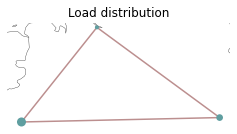

In [19]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(4, 4))
load_distribution = (network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum())
network.plot(bus_sizes=10e-4 * load_distribution, ax=ax, title="Load distribution",geomap=True)

In [20]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
p_by_carrier.columns

Index(['PV', 'gas', 'wind'], dtype='object', name='carrier')

In [21]:
colors = {
    "gas": "brown",
    "wind": "blue",
    "PV": "yellow",
}
# reorder
cols = [
    "gas",
    "wind",
    "PV",
]
p_by_carrier = p_by_carrier[cols]

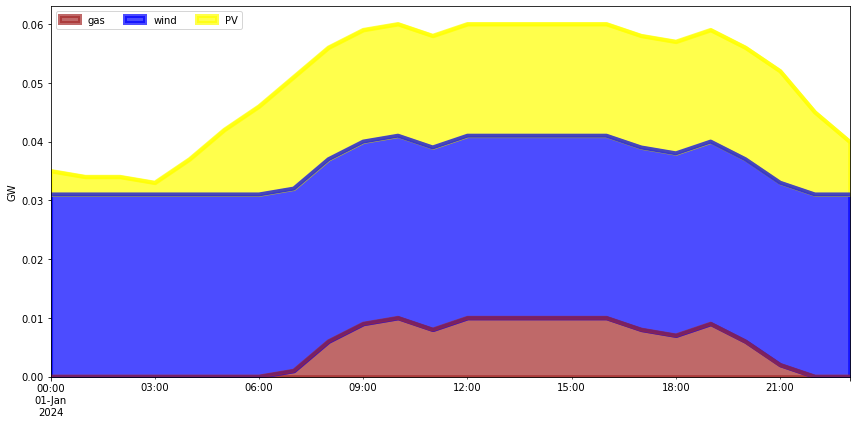

In [22]:
c = [colors[col] for col in p_by_carrier.columns]

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=c, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

In [28]:
redisp_network.lines_t.p0.iloc[1]

0     9.5
1     2.5
2   -12.0
Name: 2024-01-01 01:00:00, dtype: float64

In [24]:
def plot_graphs():
    # Calculate bus_sizes
    bus_sizes = redisp_network.generators.assign(g=redisp_network.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum() / 50

    # Get unique carriers from the bus_sizes index
    unique_carriers = bus_sizes.index.get_level_values("carrier").unique()

    # Create bus_colors dictionary dynamically
    bus_colors = {carrier: plt.cm.viridis(i / len(unique_carriers)) for i, carrier in enumerate(unique_carriers)}

    # Ensure all unique carriers in bus_sizes have corresponding colors in bus_colors
    assert set(bus_sizes.index.get_level_values("carrier")) <= set(bus_colors.keys()), "Missing colors for some carriers"

    # Plot the graph
    plot_graph = redisp_network.plot(
        bus_sizes=bus_sizes,
        bus_colors=bus_colors,
        margin=1,
        line_widths=4,
        link_widths=2,
        flow=pd.Series(round(redisp_network.lines_t.p0.iloc[1]), index=redisp_network.branches().index),
        color_geomap=True,
        projection=ccrs.EqualEarth(),
        line_colors=redisp_network.lines_t.p1.mean().abs(),
    )

    # Show the colorbar and the plot
    return plt.colorbar(plot_graph[2], fraction=0.04, pad=0.004, label="Flow in MW"), plt.show()

plot_graphs()

AttributeError: p